<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/variational_bayes_for_text_messages_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# variational Bayes for text-messages data

## data

In [ ]:
import numpy as np
from scipy.special import digamma
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [ ]:
!wget "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv"

--2022-06-07 12:19:59--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1850 (1.8K) [text/plain]
Saving to: ‘txtdata.csv.1’

txtdata.csv.1       100%[===================>]   1.81K  --.-KB/s    in 0s      

2022-06-07 12:19:59 (11.4 MB/s) - ‘txtdata.csv.1’ saved [1850/1850]



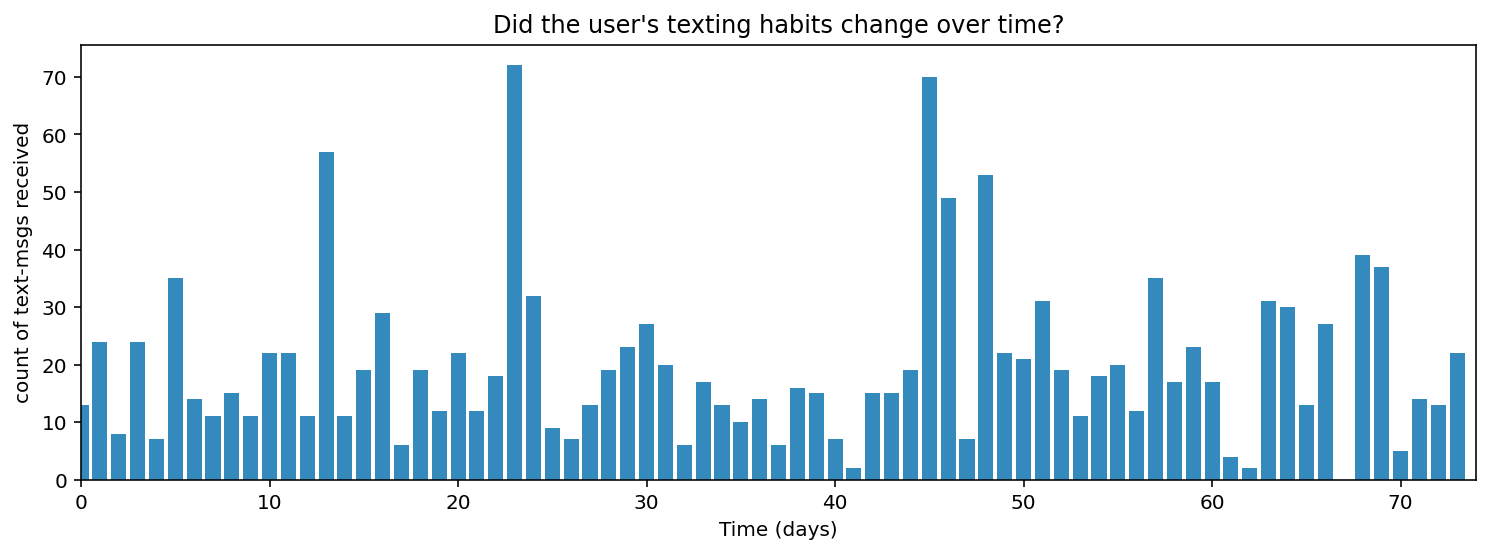

In [ ]:
PATH = 'txtdata.csv'

plt.figure(figsize=(12.5, 4))

count_data = np.loadtxt(PATH)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

## variational inference

### variational M step

In [ ]:
def M_step(count_data, cat_params, gamma_a, gamma_b):
  alpha = [gamma_a, gamma_a]
  beta = [gamma_b, gamma_b]
  n_count_data = len(count_data)
  for i in [0, 1]:
    for n in range(n_count_data):
      temp_sum = 0.0
      for tau in range(n_count_data):
        if (i == 0 and n < tau) or (i == 1 and n >= tau):
          temp_sum += cat_params[tau]
      alpha[i] +=  temp_sum * count_data[n]
      beta[i] += temp_sum
  return alpha, beta

### variational E step

In [ ]:
def E_step(count_data, alpha, beta):
  cat_params = np.zeros(n_count_data)
  for tau in range(n_count_data):
    cat_params[tau] = (digamma(alpha[0]) - np.log(beta[0])) * count_data[:tau].sum()
    cat_params[tau] += (digamma(alpha[1]) - np.log(beta[1])) * count_data[tau:].sum()
    cat_params[tau] -= (tau - 1) * alpha[0] / beta[0]
    cat_params[tau] -= (n_count_data - tau + 1) * alpha[1] / beta[1]
  cat_params -= np.max(cat_params)
  cat_params = np.exp(cat_params)
  cat_params /= cat_params.sum()
  return cat_params

### initialization of hyperparameters and posterior parameters

In [ ]:
gamma_a = 1.0
gamma_b = 1.0 / count_data.mean()
cat_params = np.exp(np.random.randn(n_count_data))
cat_params /= cat_params.sum()

### variational inference

In [ ]:
for _ in range(100):
  alpha, beta = M_step(count_data, cat_params, gamma_a, gamma_b)
  cat_params = E_step(count_data, alpha, beta)

## posterior sampling

In [ ]:
from scipy.stats import multinomial, gamma

N = 1000
tau_samples = multinomial.rvs(1, cat_params, size=N, random_state=42).argmax(1)
lambda_1_samples = gamma.rvs(alpha[0], scale=1/beta[0], size=N, random_state=42)
lambda_2_samples = gamma.rvs(alpha[1], scale=1/beta[1], size=N, random_state=42)

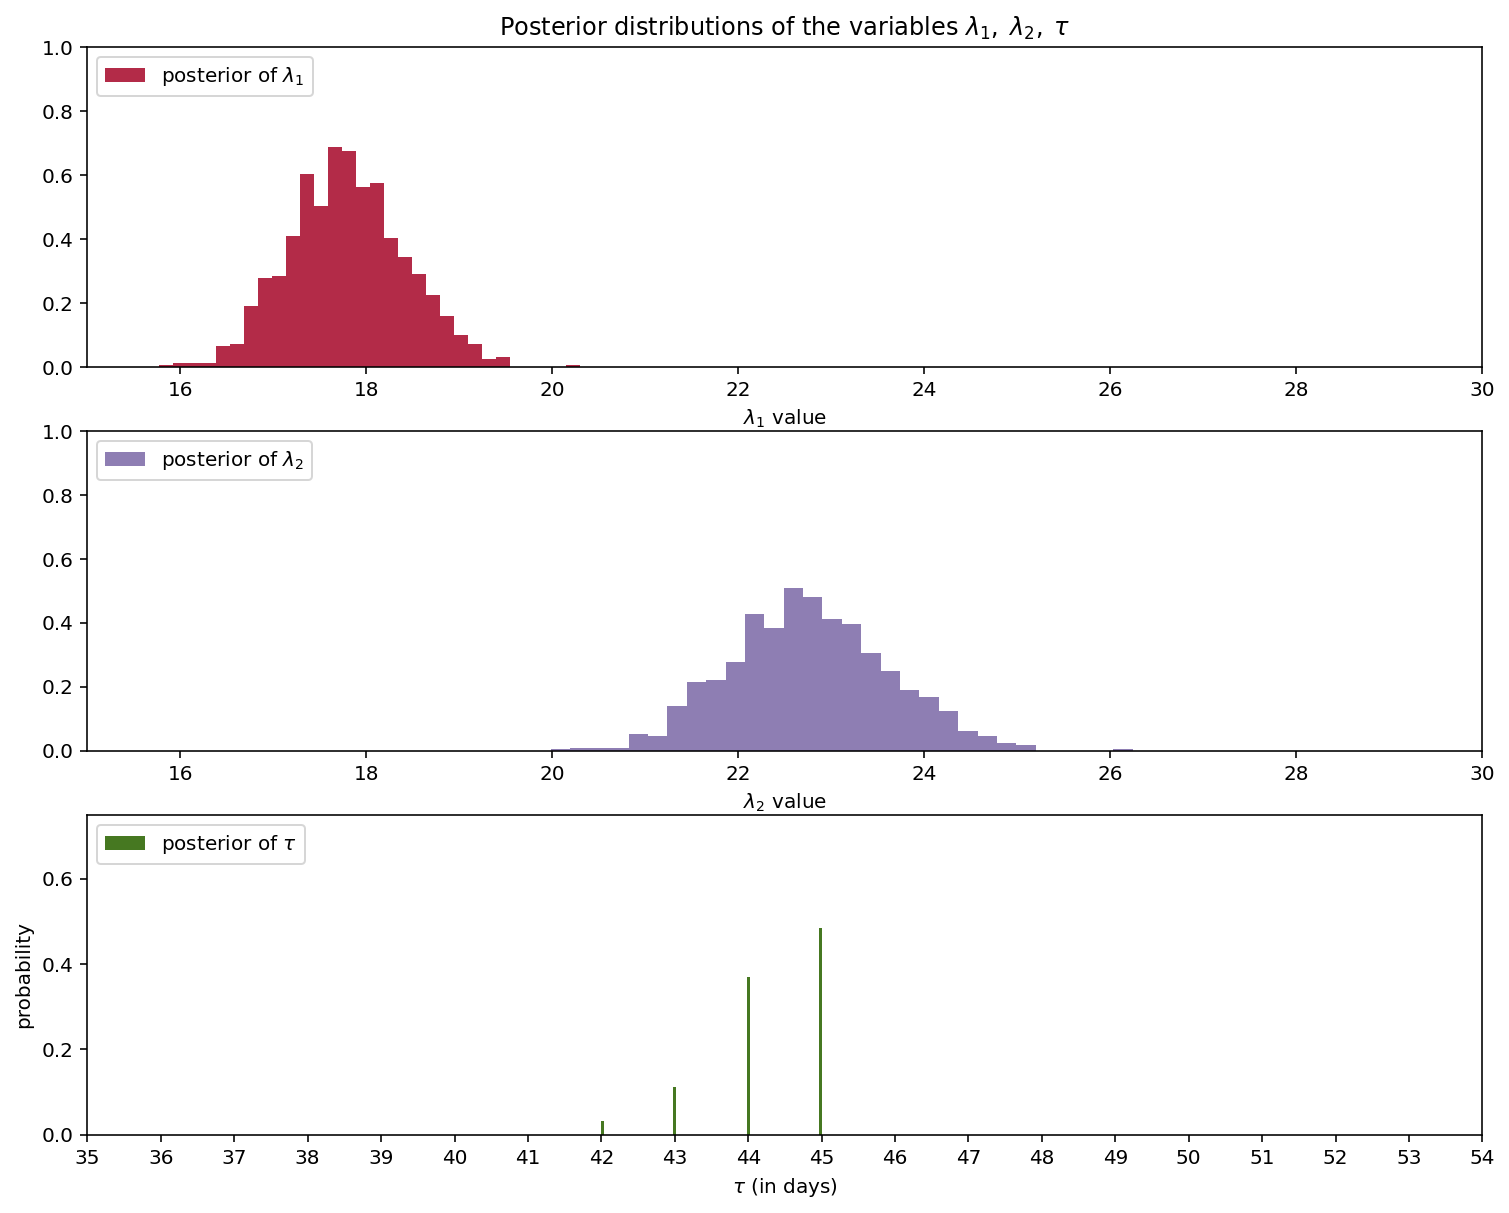

In [ ]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

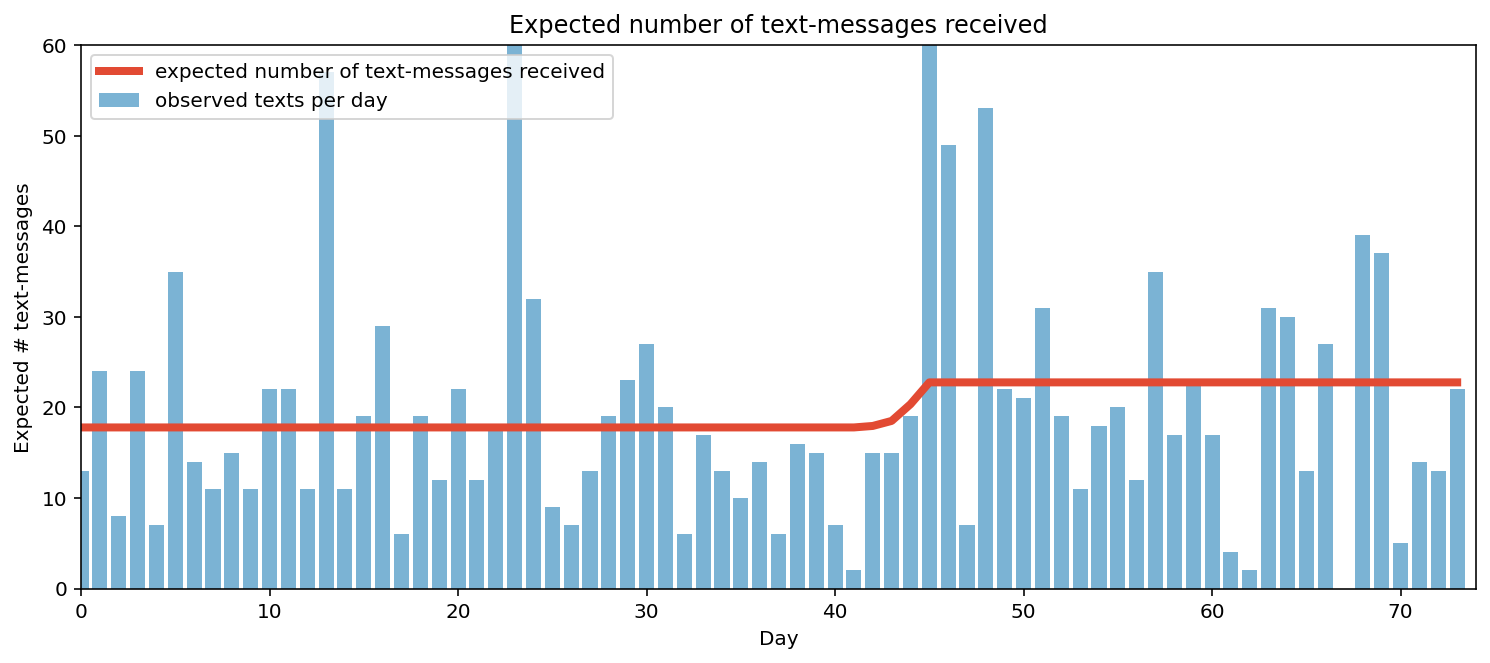

In [ ]:
plt.figure(figsize=(12.5, 5))

expected_texts_per_day = np.zeros(n_count_data)
for day in range(n_count_data):
  ix = day < tau_samples
  expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");